In [2]:
import os
import numpy as np 
import pandas as pd 
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,Conv1D,LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

Using TensorFlow backend.


In [ ]:
path = 'aclImdb/train/'

In [3]:
sentence_list = []
labels = []

print(f"Reading Positive dataset: {path}+pos/*.txt")
for filename in os.listdir(path+'pos/'):
    filepath = f"{path}/pos/{filename}"
    with open(filepath, "r") as fp:
        txt = fp.read().replace("<br />", "\n")
        sentence_list.append(txt)
        labels.append(1)

print(f"Reading Positive dataset: {path}+neg/*.txt")
for filename in os.listdir(path+'neg/'):
    filepath = f"{path}/neg/{filename}"
    with open(filepath, "r") as fp:
        txt = fp.read().replace("<br />", "\n")
        sentence_list.append(txt)
        labels.append(0)

Reading Positive dataset: aclImdb/train/+pos/*.txt
Reading Positive dataset: aclImdb/train/+neg/*.txt


In [4]:
dataset = pd.DataFrame(data={'review': sentence_list, 'label': labels})

In [5]:
dataset.shape

(25000, 2)

In [6]:
dataset['review'][3]

'This is an early film "Pilot" for the hit Canadian tv show Trailer Park Boys. It was played to executives at a few networks before Showcase decided to sign them up for a tv series. Great acting and a very funny cast make this one of the best cult comedy films. The movie plot is that these two small time criminals go around "exterminating" peoples pets for money. If you have a dog next door whos barking all night these are the guys you go to! But they get into trouble when they come across a job too big for them to deal with and end up in a shootout. Watch this movie if you want to understand the beginning of the tv series. I highly recommend it!\n\nRated R for swearing, violence, and drug use.\n\nIts not too offensive either (they dont actually show killing animals)'

### PreProcessing Reviews


In [7]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocessing_text(text):
    # Remove html tag
    sentence = remove_tags(text)
    # Remove link
    sentence = re.sub(r'https:\/\/[a-zA-Z]*\.com',' ',sentence)
    # Remove number
    sentence = re.sub(r'\d+',' ',sentence)
    # Remove white space
    sentence = re.sub(r'\s+',' ',sentence)
    # Remove single character
    sentence = re.sub(r"\b[a-zA-Z]\b", ' ', sentence)
    # Remove bracket
    sentence = re.sub(r'\W+',' ',sentence)
    # Make sentence lowercase
    sentence = sentence.lower()
    return sentence

In [8]:
dataset['review'][5]

'I cannot accept the negative comments of other reviewers. They are too critical, perhaps because they are stuck in the past. I would like to see a comment from someone who had never seen Basic Instinct 1, perhaps someone very young ? I left the cinema feeling glad that I had not been swayed by the IMDb reviewers. 14 hours later I am still trying to find flaws in the plot but I cannot think of anything serious. My advice to everyone is see it for yourself and make up your own mind.\n\nIt follows a similar pattern to Basic Instinct 1 but the plot is less confused. It still left me wondering at the end but in a more satisfactory way. Sharon Stone is as sexy and evil as before and wears her 48 years extremely well; this remains her defining role. David Morrisey was satisfactory even though he is no Michael Douglas. Of the supporting cast I particularly liked David Thewlis as the police detective.'

In [9]:
pre_proces_sen = []
sentences = list(dataset['review'])
for sen in tqdm(sentences):
    pre_proces_sen.append(preprocessing_text(sen))

100%|██████████| 25000/25000 [00:05<00:00, 4924.78it/s]


In [10]:
pre_proces_sen[5]

' cannot accept the negative comments of other reviewers they are too critical perhaps because they are stuck in the past would like to see comment from someone who had never seen basic instinct perhaps someone very young left the cinema feeling glad that had not been swayed by the imdb reviewers hours later am still trying to find flaws in the plot but cannot think of anything serious my advice to everyone is see it for yourself and make up your own mind it follows similar pattern to basic instinct but the plot is less confused it still left me wondering at the end but in more satisfactory way sharon stone is as sexy and evil as before and wears her years extremely well this remains her defining role david morrisey was satisfactory even though he is no michael douglas of the supporting cast particularly liked david thewlis as the police detective '

### Removing Stopwords

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /home/aksel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aksel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
stopwords=set(stopwords.words('english'))

In [13]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [14]:
for i in tqdm(range(len(pre_proces_sen))):
    x = pre_proces_sen[i]
    x = word_tokenize(x)
    new_x_list = [word for word in x if word not in stopwords]
    pre_proces_sen[i] = ' '.join(new_x_list)

100%|██████████| 25000/25000 [00:18<00:00, 1364.81it/s]


In [15]:
pre_proces_sen[5]

'accept negative comments reviewers critical perhaps stuck past would like see comment someone never seen basic instinct perhaps someone young left cinema feeling glad swayed imdb reviewers hours later still trying find flaws plot think anything serious advice everyone see make mind follows similar pattern basic instinct plot less confused still left wondering end satisfactory way sharon stone sexy evil wears years extremely well remains defining role david morrisey satisfactory even though michael douglas supporting cast particularly liked david thewlis police detective'

In [16]:
dataset['review'] = pre_proces_sen

In [17]:
dataset.head()

,review,label
0,william shakespeare would proud particular ver...,1
1,half dozen short stories varying interest enli...,1
2,easy call guys dolls great got frank sinatra m...,1
3,early film pilot hit canadian tv show trailer ...,1
4,delightful disney film angela lansbury fine fo...,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(dataset['review'].values,
                                                    dataset['label'].values, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review'].values)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

73395


In [21]:
EMBED_DIM = 500

In [24]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii
from keras import optimizers
from keras.utils import to_categorical
from keras import regularizers

model = Sequential()
model.add(Embedding(vocab_size, EMBED_DIM, input_length=maxlen, embeddings_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.4)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=['acc'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         100
           Embedding   emb | -------------------  36697500    98.3%
                       #####    100  500
             Dropout    | || -------------------         0     0.0%
                       #####    100  500
       Bidirectional   ????? -------------------    644096     1.7%
                       #####         256
             Dropout    | || -------------------         0     0.0%
                       #####         256
               Dense   XXXXX -------------------       257     0.0%
             sigmoid   #####           1


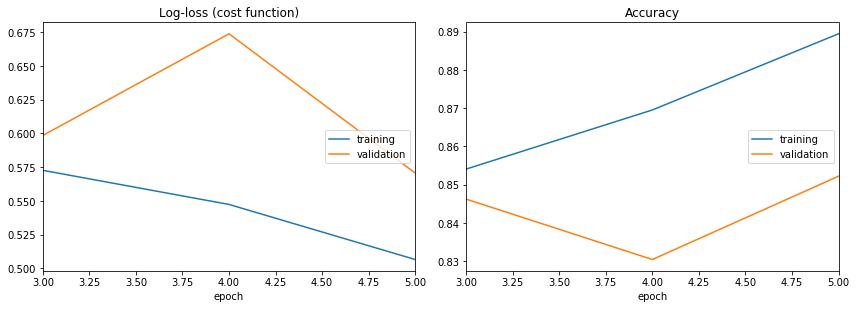

0it [00:00, ?it/s]

Log-loss (cost function):
training   (min:    0.507, max:    1.389, cur:    0.507)
validation (min:    0.571, max:    0.674, cur:    0.571)

Accuracy:
training   (min:    0.718, max:    0.889, cur:    0.889)
validation (min:    0.804, max:    0.852, cur:    0.852)


In [26]:
history = tqdm(model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()],
                    verbose=1))

In [27]:
y_pred = model.predict_classes(X_test)
evaluation1 = model.evaluate(X_test, y_test)
acc1 = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred, average='weighted')
print(evaluation1)
print('Accuracy: ', acc1)
print('F1 score: ', f1_1)

5000/5000 [==============================] - 16s 3ms/step
[0.5618007720947266, 0.851]
Accuracy:  0.851
F1 score:  0.8509417241582818


In [28]:
reviews = []
for i in range(len(pre_proces_sen)):
    reviews.append(pre_proces_sen[i].split())

In [29]:
%%time
import gensim
word2vec = gensim.models.Word2Vec(sentences=reviews,size=EMBED_DIM,
                                  window=5,workers=4,min_count=3)

CPU times: user 1min 1s, sys: 117 ms, total: 1min 1s
Wall time: 1min 1s


In [30]:
words=list(word2vec.wv.vocab)
print("vocabulary size:",len(words))

vocabulary size: 37248


In [31]:
words[:10]

['william',
 'shakespeare',
 'would',
 'proud',
 'particular',
 'version',
 'play',
 'best',
 'movie',
 'also']

In [32]:
embedding_weights = np.zeros((vocab_size, EMBED_DIM))
for word, index in tokenizer.word_index.items():
    try:
        embedding_weights[index] = word2vec.wv.get_vector(word)
    except:
        pass 

In [33]:
from keras.initializers import Constant

In [72]:
model = Sequential()
model.add(Embedding(vocab_size, EMBED_DIM, input_length=maxlen, embeddings_regularizer=regularizers.l2(0.001),
                   weights=[embedding_weights]))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.4)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=['acc'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         100
           Embedding   emb | -------------------  36697500    98.3%
                       #####    100  500
             Dropout    | || -------------------         0     0.0%
                       #####    100  500
       Bidirectional   ????? -------------------    644096     1.7%
                       #####         256
             Dropout    | || -------------------         0     0.0%
                       #####         256
               Dense   XXXXX -------------------       257     0.0%
             sigmoid   #####           1


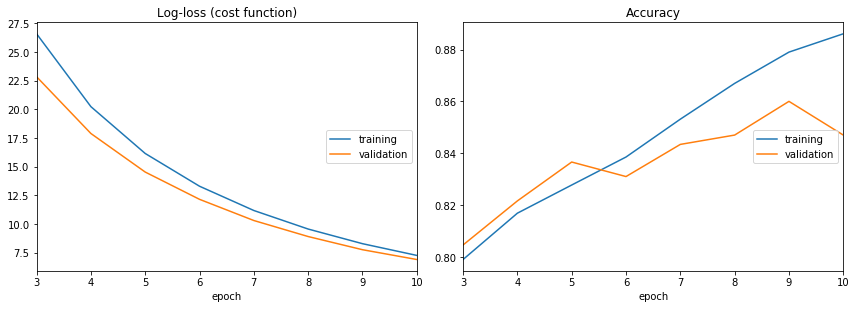







0it [00:00, ?it/s]

Log-loss (cost function):
training   (min:    7.267, max:   74.862, cur:    7.267)
validation (min:    6.910, max:   47.398, cur:    6.910)

Accuracy:
training   (min:    0.688, max:    0.886, cur:    0.886)
validation (min:    0.765, max:    0.860, cur:    0.847)


In [73]:
history = tqdm(model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()],
                    verbose=1))

In [74]:
y_pred = model.predict_classes(X_test)
evaluation1 = model.evaluate(X_test, y_test)
acc1 = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred, average='weighted')
print(evaluation1)
print('Accuracy: ', acc1)
print('F1 score: ', f1_1)

5000/5000 [==============================] - 16s 3ms/step
[6.8980816513061525, 0.8488]
Accuracy:  0.8488
F1 score:  0.8479178939382327


In [35]:
from keras.layers import MaxPooling1D

In [39]:
model = Sequential()
model.add(Embedding(vocab_size, EMBED_DIM, input_length=maxlen,
                    weights=[embedding_weights]))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(LSTM(64, recurrent_dropout=0.4))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=['acc'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         100
           Embedding   emb | -------------------  36697500    99.3%
                       #####    100  500
              Conv1D    \|/  -------------------    192128     0.5%
                relu   #####    100  128
             Dropout    | || -------------------         0     0.0%
                       #####    100  128
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####     50  128
             Dropout    | || -------------------         0     0.0%
                       #####     50  128
                LSTM   LLLLL -------------------     49408     0.1%
                tanh   #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------        65     0.0%
             sigmoid   #####           1


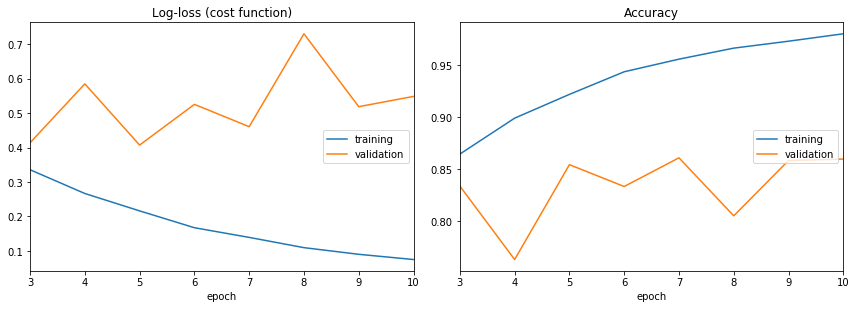



0it [00:00, ?it/s]

Log-loss (cost function):
training   (min:    0.075, max:    0.619, cur:    0.075)
validation (min:    0.407, max:    0.731, cur:    0.549)

Accuracy:
training   (min:    0.649, max:    0.980, cur:    0.980)
validation (min:    0.763, max:    0.861, cur:    0.860)


In [40]:
history = tqdm(model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()],
                    verbose=1))

In [41]:
y_pred = model.predict_classes(X_test)
evaluation1 = model.evaluate(X_test, y_test)
acc1 = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred, average='weighted')
print(evaluation1)
print('Accuracy: ', acc1)
print('F1 score: ', f1_1)

5000/5000 [==============================] - 5s 992us/step
[0.5437909519642592, 0.8612]
Accuracy:  0.8612
F1 score:  0.8612005774083696
